# CIFAR-10 CNN

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 60.000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 casses com 6.000 imagens por classe. 

O exemplo abaixo é uma adaptação do exemplo fornecido na documentação do Keras: 
https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py Nele, nós utilizamos apenas 3 das 10 classes. A saída das diferentes camadas da CNN são mostradas.

In [4]:
!nvidia-smi

Wed Feb 22 12:44:31 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.57                 Driver Version: 367.57                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           On   | 0000:00:03.0     Off |                  N/A |
| N/A   32C    P8    18W / 125W |     51MiB /  4036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Importando as bibliotecas

In [5]:
#Importando as bibliotecas necessárias
%matplotlib inline
import numpy as np
import sys
np.random.seed(1337)  # for reproducibility
import matplotlib.pylab as plt
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import numpy as np
import cv2
import theano

## Carregando e mostrando os dados

('X_train shape:', (15000, 1, 32, 32))
(15000, 'amostras de treinamento')
(3000, 'amostras de teste')


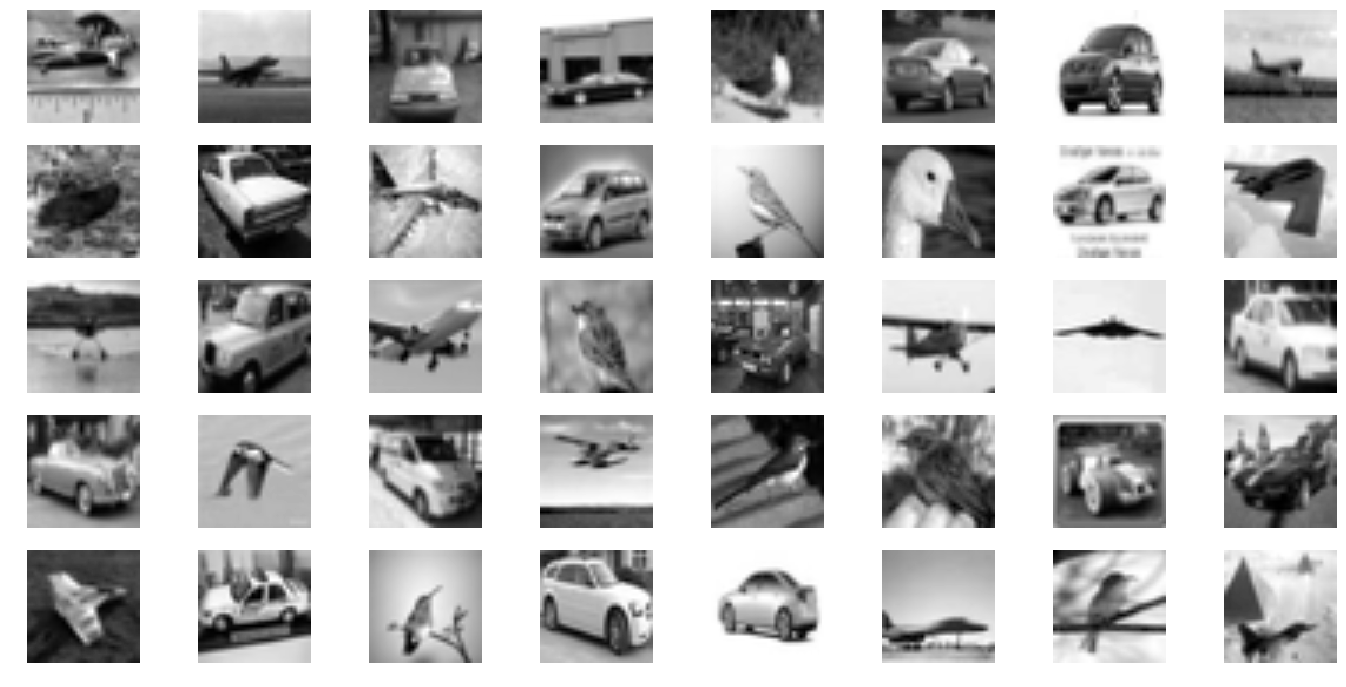

In [6]:
nb_classes = 3 #Número de classes

# Carregando os dados
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()


#Selecionando apenas objetos das classes: 0, 1, 2
indexes_train = (y_train == 0) | (y_train == 1) | (y_train == 2)
X_train = X_train[indexes_train].mean(axis=1,keepdims = True) #RGB para cinza
y_train = y_train[indexes_train]

indexes_test = (y_test == 0) | (y_test == 1) | (y_test == 2) 
X_test = X_test[indexes_test].mean(axis=1,keepdims = True) #RGB para cinza
y_test = y_test[indexes_test]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

#Mostrando algumas imagens do conjunto de teste
plt.figure(figsize=(24, 12))

for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(40,))):
    plt.subplot(5, 8, k + 1)
    image = (X_test[i])
    image = cv2.resize(image[0], (96, 96), interpolation=cv2.INTER_LINEAR)
    
    # mostra as imagens
    plt.imshow(image,cmap = 'gray')
    plt.axis('off')
    
# Transforma o vetor de labes para o formato de one-hot encoding.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Normalização dos dados
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


# Construíndo a CNN com o Keras

In [8]:
def model_build():
    batch_size = 100
    nb_epoch = 25 # Numero de épocas
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    input_shape = (1, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    model.add(Convolution2D(32, 3, 3,
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(32,3,3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

[INFO] evaluating...
2944/3000 [============================>.] - ETA: 0s[INFO] accuracy: 85.73%


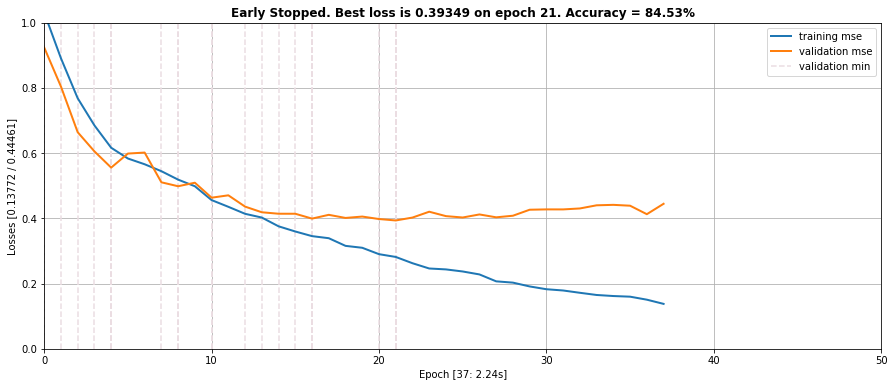

In [9]:
nepochs = 50
ploss = 1.0
sys.path.append("../src")
from my_keras_utilities import TrainingPlotter, load_model_and_history
model_name = './cifar_1'

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = model_build()
    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, my_big_callback = load_model_and_history(model_name)

past_epochs = my_big_callback.get_nepochs()

fig = plt.figure(figsize=(15,6))
plt.ylim(0.0, ploss)
plt.xlim(0, nepochs)
plt.grid(True)

print("[INFO] training...")
try:
    histo2 = model.fit(X_train, Y_train, batch_size=128, nb_epoch=nepochs - past_epochs, 
                       verbose=0, validation_split=0.33, callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating...")
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

In [10]:
#Função que desenha o mosaico
def mosaic(f,N):
    d,h,w = f.shape
    nLines = np.ceil(float(d)/N)
    nCells = nLines*N
        
    fullf = np.resize(f, (nCells,h,w))
    fullf[d:nCells,:,:] = 0        
        
    Y,X = np.indices((nLines*h,N*w))
    Pts = np.array([
                   (np.floor(Y/h)*N + np.floor(X/w)).ravel(),
                   np.mod(Y,h).ravel(),
                   np.mod(X,w).ravel() ]).astype(int).reshape((3,int(nLines*h),int(N*w)))
    g = fullf[Pts[0],Pts[1],Pts[2]]
    return g

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 30, 30)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 30, 30)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 28, 28)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 32, 28, 28)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


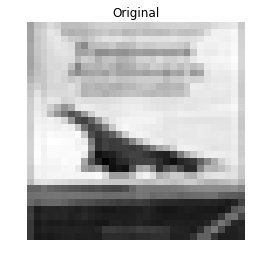

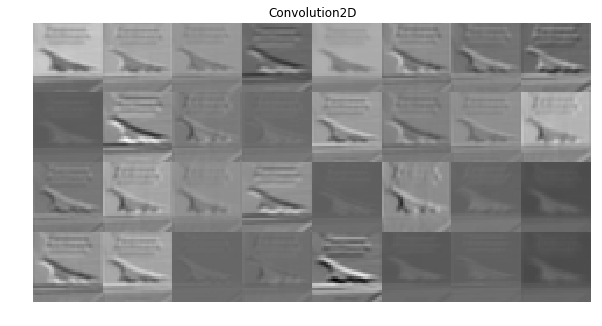

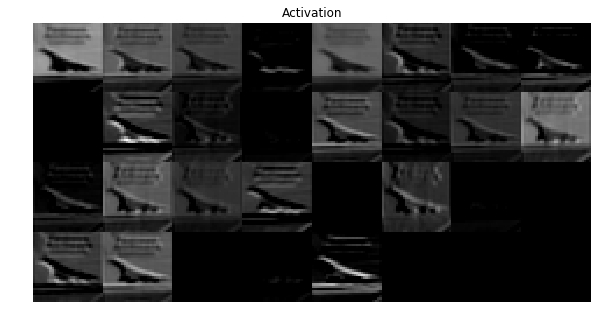

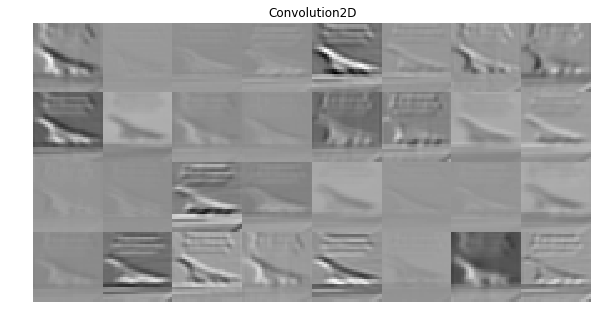

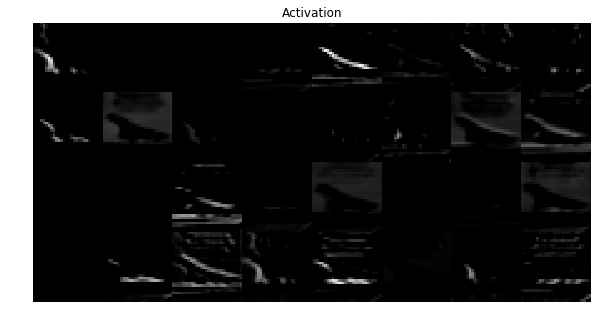

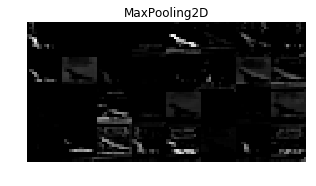

In [14]:
sn = 0
plt.figure()
plt.imshow(X_test[sn,0,:,:],cmap = 'gray')
plt.axis('off')
plt.title("Original")
ncols = 8
H,W = 10,30

model.summary()

#Mostrando a saida das camadas convolucionais
for layer in model.layers[0:5]:
    intermediate_layer_model = Model(input=model.input,output=layer.output)
    intermediate_output = intermediate_layer_model.predict(X_test[sn].reshape(1,1,32,32))
    sub_dim = intermediate_output.shape[1]
    name = str(layer).split('.')[3].split(" ")[0]
    if name =="MaxPooling2D":
        H = H/2
        W = W/2
    fig =plt.figure(figsize=(H,W))
    aux = intermediate_output[0,:,:,:]
    mos = mosaic(aux,ncols)
    plt.imshow(mos,cmap = 'gray')
    plt.axis('off')
    plt.title(name)

## Atividades

1. Quantos parâmetros são treinados nesta rede? Calcule o número de parâmetros de cada camada, não se esquecendo do *bias*. Confira o valor calculado com o `summary` do Keras.


## Aprendizados com este experimento

Atividade: 
```py
model.add(Convolution2D(32, 3, 3,
    border_mode='valid',
    input_shape=input_shape)) # 32 x 3 x 3 + 32 = 320
model.add(Activation('relu'))
model.add(Convolution2D(32,3,3)) # 32 x 32 x 3 x 3 + 32 = 9248
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.25))

# Aqui os features deixam de ser imagens
model.add(Flatten())
model.add(Dense(128)) # 32 x 14 x 14 x 128 + 128 [border_mode = 'valid' diminuiu o tamanho + maxpooling]
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes)) # 128 * 3 + 3 = 38
model.add(Activation('softmax'))
```

- A convnet está retirando os atributos e a rede densa classificando
- 